<a href="https://colab.research.google.com/github/Joykarmoker71/Thesis-product-placement/blob/main/total_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score #evaluation matric, For regression problem's accuracy, just like conf. matrice in classification task
from tensorflow.keras.models import Sequential #Sequential model is a linear stack of layers. 
from tensorflow.keras.layers import Dense, LSTM, Flatten #Layers are the basic building blocks of neural networks in Keras.
# The dense layer in neural networks is the one that executes matrix-vector multiplication. And, LSTM is a variety of recurrent neural networks (RNNs) that are capable of learning long-term dependencies, especially in sequence prediction problems.
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #Callbacks are useful to get a view on internal states and statistics of the model during training.
#EarlyStopping is a callback used while training neural networks, which provides us the advantage of using a large number of training epochs and stopping the training once the model's performance stops improving on the validation Dataset.
#ModelCheckpoint callback is used in conjunction with training using model. fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
store_sales = pd.read_csv('/content/drive/MyDrive/THESIS/prediction/Report (1).csv')
store_sales.head(10)

,INVOICE,S_CODE,CLASS_NAME,CODE,NAME,QTY,RATE,TOTAL,COST_PRICE
0,OC3801-01-2201000001,1/1/2022,Sweet & Fast Food,2500000114,Tasty Treat Butter Bun 100gm,1.0,30.0,30.0,21.60
1,OC3801-01-2201000001,1/1/2022,Beverage,3000000463,Coca-Cola 250ml Zero PET,1.0,20.0,20.0,13.86
2,OC3801-01-2201000001,1/1/2022,Beverage,3000000435,Royal Crown Club Soda 500ml,1.0,30.0,30.0,25.00
3,OC3801-01-2201000001,1/1/2022,Personal Care,6000001263,Himalaya Aloe Vera Face Wash 100ml,1.0,190.0,190.0,142.50
4,OC3801-01-2201000002,1/1/2022,Packaged Food,5500000565,All Time Milk Bread 300gm,1.0,45.0,45.0,34.20
5,OC3801-01-2201000002,1/1/2022,Packaged Food,5500000349,PRAN Jhatpat Paratha Low Fat 10pcs 600gm,1.0,100.0,100.0,72.00
6,OC3801-01-2201000002,1/1/2022,Packaged Food,5500000402,All Time Sandwich Bread 300gm,1.0,40.0,40.0,29.90
7,OC3801-01-2201000002,1/1/2022,Commodities,3500000120,BSFIC Brown Sugar 1kg,1.0,85.0,85.0,66.57
8,OC3801-01-2201000003,1/1/2022,Packaged Food,5500000078,PRAN Mr. Noodle 12ps Magic Masala,1.0,210.0,210.0,157.22
9,OC3801-01-2201000003,1/1/2022,Packaged Food,5500001605,Pringles Original 42gm (Malaysia),1.0,100.0,100.0,80.00


NULL CHECK

In [7]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158293 entries, 0 to 158292
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   INVOICE     158293 non-null  object 
 1   S_CODE      158293 non-null  object 
 2   CLASS_NAME  158293 non-null  object 
 3   CODE        158293 non-null  int64  
 4   NAME        158293 non-null  object 
 5   QTY         158293 non-null  float64
 6   RATE        158293 non-null  float64
 7   TOTAL       158293 non-null  float64
 8   COST_PRICE  158293 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 10.9+ MB


Drop Irrelevant Column

In [8]:
store_sales = store_sales.drop(['INVOICE','CLASS_NAME','CODE','NAME','RATE','TOTAL','COST_PRICE'], axis=1)


In [9]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158293 entries, 0 to 158292
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   S_CODE  158293 non-null  object 
 1   QTY     158293 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.4+ MB


Rename column

In [10]:
store_sales.rename(columns = {'S_CODE':'Date'}, inplace = True)

In [11]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158293 entries, 0 to 158292
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Date    158293 non-null  object 
 1   QTY     158293 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.4+ MB


Convert to datetime datatype -> "Date"

In [12]:
store_sales['Date'] = pd.to_datetime(store_sales['Date'])

Monthly Sales

In [13]:
store_sales['Date'] = store_sales['Date'].dt.to_period('M')
monthly_sales = store_sales.groupby('Date')['QTY'].sum().reset_index()

In [14]:
monthly_sales

,Date,QTY
0,2022-01,38855.50
1,2022-02,30831.85
2,2022-03,27753.50
3,2022-04,31835.38
4,2022-05,30124.15
5,2022-06,26870.37
6,2022-07,33578.60
7,2022-08,31325.47
8,2022-09,29487.76
9,2022-10,29907.18


In [15]:
type(monthly_sales)

pandas.core.frame.DataFrame

Convert to timestamp datatype

In [16]:
monthly_sales['Date'] = monthly_sales['Date'].dt.to_timestamp()
monthly_sales.head()

,Date,QTY
0,2022-01-01,38855.50
1,2022-02-01,30831.85
2,2022-03-01,27753.50
3,2022-04-01,31835.38
4,2022-05-01,30124.15


In [17]:
monthly_sales

,Date,QTY
0,2022-01-01,38855.50
1,2022-02-01,30831.85
2,2022-03-01,27753.50
3,2022-04-01,31835.38
4,2022-05-01,30124.15
5,2022-06-01,26870.37
6,2022-07-01,33578.60
7,2022-08-01,31325.47
8,2022-09-01,29487.76
9,2022-10-01,29907.18


Visualiztion

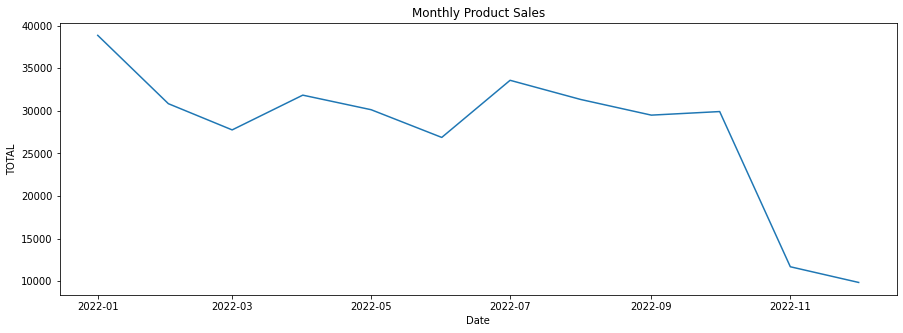

In [18]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['Date'], monthly_sales['QTY'])
plt.xlabel('Date')
plt.ylabel('TOTAL')
plt.title("Monthly Product Sales")
plt.show()

Time Plot

In [19]:
df_new = monthly_sales.copy()
df_new['Time'] = np.arange(len(df_new.index))

df_new.head()

,Date,QTY,Time
0,2022-01-01,38855.50,0
1,2022-02-01,30831.85,1
2,2022-03-01,27753.50,2
3,2022-04-01,31835.38,3
4,2022-05-01,30124.15,4


In [20]:
monthly_sales

,Date,QTY
0,2022-01-01,38855.50
1,2022-02-01,30831.85
2,2022-03-01,27753.50
3,2022-04-01,31835.38
4,2022-05-01,30124.15
5,2022-06-01,26870.37
6,2022-07-01,33578.60
7,2022-08-01,31325.47
8,2022-09-01,29487.76
9,2022-10-01,29907.18


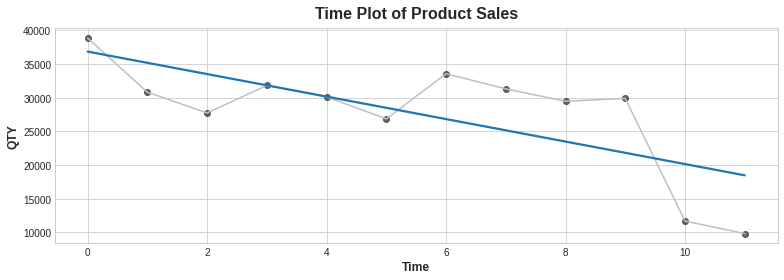

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
    )

fig, ax = plt.subplots()
ax.plot('Time', 'QTY', data=df_new, color='0.75')
ax = sns.regplot(x='Time', y='QTY', data=df_new, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Product Sales');

Decreasing over time. So, we make it stationary. Calling difference on the QTY column to make data stationary

To be asboslutely sure, we do adfuller test

In [22]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

In [23]:
test_result=adfuller(monthly_sales['QTY'])

In [24]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [25]:
adfuller_test(monthly_sales['QTY'])

ADF Test Statistic : -0.4721116415963219
p-value : 0.8973447892476756
#Lags Used : 3
Number of Observations Used : 8
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [26]:
monthly_sales['TOTAL_diff'] = monthly_sales['QTY'].diff() #current month sale - previous month sale
monthly_sales = monthly_sales.dropna() #removing row with null value
monthly_sales.head

<bound method NDFrame.head of          Date       QTY  TOTAL_diff
1  2022-02-01  30831.85    -8023.65
2  2022-03-01  27753.50    -3078.35
3  2022-04-01  31835.38     4081.88
4  2022-05-01  30124.15    -1711.23
5  2022-06-01  26870.37    -3253.78
6  2022-07-01  33578.60     6708.23
7  2022-08-01  31325.47    -2253.13
8  2022-09-01  29487.76    -1837.71
9  2022-10-01  29907.18      419.42
10 2022-11-01  11684.43   -18222.75
11 2022-12-01   9842.18    -1842.25>

In [27]:
monthly_sales.head()

,Date,QTY,TOTAL_diff
1,2022-02-01,30831.85,-8023.65
2,2022-03-01,27753.50,-3078.35
3,2022-04-01,31835.38,4081.88
4,2022-05-01,30124.15,-1711.23
5,2022-06-01,26870.37,-3253.78


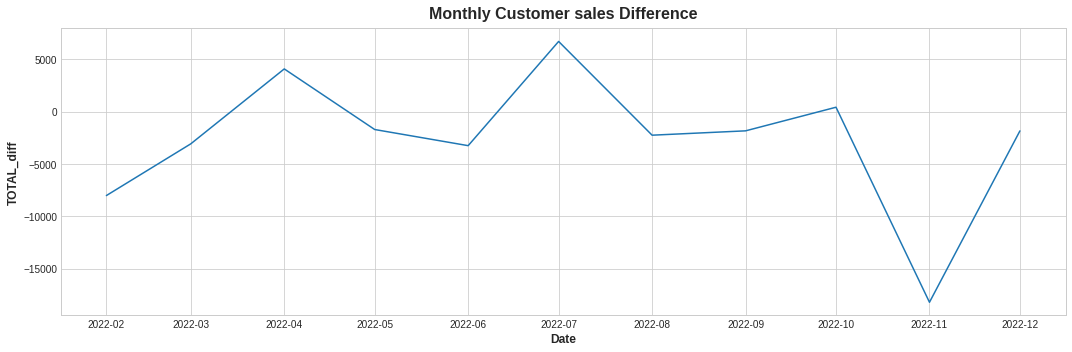

In [28]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['Date'], monthly_sales['TOTAL_diff'])
plt.xlabel('Date')
plt.ylabel('TOTAL_diff')
plt.title("Monthly Customer sales Difference")
plt.show()

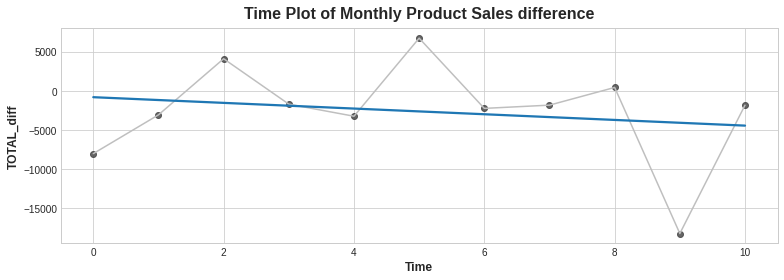

In [29]:
df_new = monthly_sales.copy()
df_new['Time'] = np.arange(len(df_new.index))


import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
    )

fig, ax = plt.subplots()
ax.plot('Time', 'TOTAL_diff', data=df_new, color='0.75')
ax = sns.regplot(x='Time', y='TOTAL_diff', data=df_new, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Monthly Product Sales difference');

Dropping Date & QTY

In [30]:
supervised_data=monthly_sales.drop(['Date','QTY'],axis=1)

preparing supervised data with training for 3 months and then testing in the next 3 cause the data gets shortened a lot 

In [31]:
for i in range(1,6): #Can not give 1,12 cause it would result in at least one nan value in every column. Thus iterating only 6 times
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['TOTAL_diff'].shift(i) #shift(i) means shifting the iterator for desired no. of periods
    #print(supervised_data) #Run this for any confusion
supervised_data = supervised_data.dropna().reset_index(drop=True) #dropping rows with nan values
supervised_data
#For any time series, preprocess data in such a way that we can create ind. and dep. features based on no. of time steps

,TOTAL_diff,month_1,month_2,month_3,month_4,month_5
0,6708.23,-3253.78,-1711.23,4081.88,-3078.35,-8023.65
1,-2253.13,6708.23,-3253.78,-1711.23,4081.88,-3078.35
2,-1837.71,-2253.13,6708.23,-3253.78,-1711.23,4081.88
3,419.42,-1837.71,-2253.13,6708.23,-3253.78,-1711.23
4,-18222.75,419.42,-1837.71,-2253.13,6708.23,-3253.78
5,-1842.25,-18222.75,419.42,-1837.71,-2253.13,6708.23


Train,test

In [32]:
print(supervised_data[:-3])
supervised_data[-3:]

   TOTAL_diff  month_1  month_2  month_3  month_4  month_5
0     6708.23 -3253.78 -1711.23  4081.88 -3078.35 -8023.65
1    -2253.13  6708.23 -3253.78 -1711.23  4081.88 -3078.35
2    -1837.71 -2253.13  6708.23 -3253.78 -1711.23  4081.88


,TOTAL_diff,month_1,month_2,month_3,month_4,month_5
3,419.42,-1837.71,-2253.13,6708.23,-3253.78,-1711.23
4,-18222.75,419.42,-1837.71,-2253.13,6708.23,-3253.78
5,-1842.25,-18222.75,419.42,-1837.71,-2253.13,6708.23


In [33]:
train_data = supervised_data[:-3].values #Training first 3 rows, doing this with 4 eows give better features lmao
test_data = supervised_data[-3:].values
print('Train Data Shape:', train_data.shape)
print('Test Data Shape:', test_data.shape)

Train Data Shape: (3, 6)
Test Data Shape: (3, 6)


In [34]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [35]:
#In supervised df, first column always corresponds to output and rest as input features
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel() #ravel is used to change a 2-dimensional array or a multi-dimensional array into a contiguous flattened array.
y_test = y_test.ravel()
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (3, 5)
y_train Shape: (3,)
X_test Shape: (3, 5)
y_test Shape: (3,)


Making prediction df to merge the predicted sales of all trained algos

In [36]:
sales_dates = monthly_sales['Date'][-3:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [37]:
actual_sales=monthly_sales['QTY'][-3:].to_list()
print(actual_sales)

[29907.18, 11684.43, 9842.18]


# linear regression

In [38]:
linearreg_model=LinearRegression()
linearreg_model.fit(X_train,y_train)
linearreg_prediction=linearreg_model.predict(X_test)

In [39]:
linearreg_prediction=linearreg_prediction.reshape(-1,1)
lr_pre_test_set=np.concatenate([linearreg_prediction,X_test],axis=1)
lr_pre_test_set=scaler.inverse_transform(lr_pre_test_set) #Transforming predicted values to original self

In [40]:
result_list = []
for index in range(0, len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0] + actual_sales[index])
lr_pre_series = pd.Series(result_list,name='linear prediction')
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)


In [41]:
print(predict_df)

        Date  linear prediction
0 2022-10-01       36235.825423
1 2022-11-01        9576.887170
2 2022-12-01       13023.036596


In [42]:
lr_mse = np.sqrt(mean_squared_error(predict_df['linear prediction'], monthly_sales['QTY'][-3:]))
lr_mae = mean_absolute_error(predict_df['linear prediction'], monthly_sales['QTY'][-3:])
lr_r2 = r2_score(predict_df['linear prediction'], monthly_sales['QTY'][-3:])
print('Linear Regression MSE: ', lr_mse)
print('Linear Regression MAE: ', lr_mae)
print('Linear Regression R2 Score: ', lr_r2)

Linear Regression MSE:  4266.588736896289
Linear Regression MAE:  3872.3482828782794
Linear Regression R2 Score:  0.8701181932108707


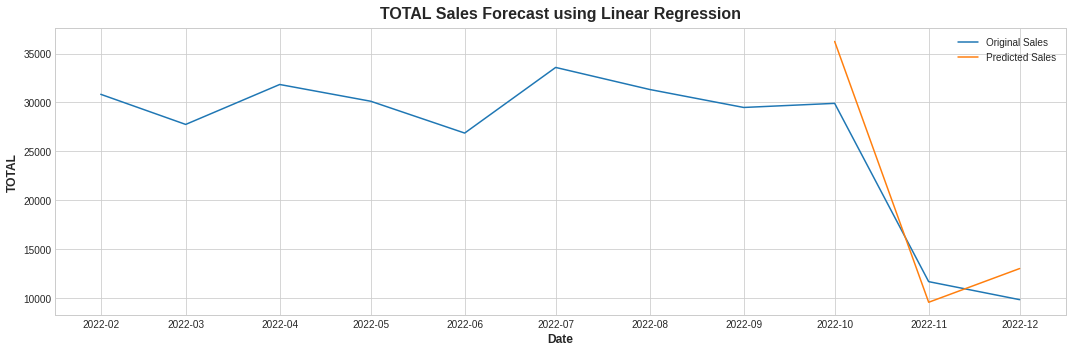

In [43]:
plt.figure(figsize=(15,5))
#Actual sales
plt.plot(monthly_sales['Date'], monthly_sales['QTY'])
#Predicted sales
plt.plot(predict_df['Date'], predict_df['linear prediction'])
plt.title("TOTAL Sales Forecast using Linear Regression")
plt.xlabel("Date")
plt.ylabel("TOTAL")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()

# RANDOM FOREST REGRESSOR

In [44]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=20)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

In [45]:
rf_pred = rf_pred.reshape(-1,1)
rf_pred_test_set = np.concatenate([rf_pred,X_test], axis=1)
rf_pred_test_set = scaler.inverse_transform(rf_pred_test_set)

In [46]:
result_list = []
for index in range(0, len(rf_pred_test_set)):
    result_list.append(rf_pred_test_set[index][0] + actual_sales[index])
rf_pred_series = pd.Series(result_list, name='rf_pred')
predict_df = predict_df.merge(rf_pred_series, left_index=True, right_index=True)


In [47]:
rf_rmse = np.sqrt(mean_squared_error(predict_df['rf_pred'], monthly_sales['QTY'][-3:]))
rf_mae = mean_absolute_error(predict_df['rf_pred'], monthly_sales['QTY'][-3:])
rf_r2 = r2_score(predict_df['rf_pred'], monthly_sales['QTY'][-3:])
print('Random Forest RMSE: ', rf_rmse)
print('Random Forest MAE: ', rf_mae)
print('Random Forest R2 Score: ', rf_r2)

Random Forest RMSE:  1747.799998535866
Random Forest MAE:  1389.791066666666
Random Forest R2 Score:  0.9702084955745494


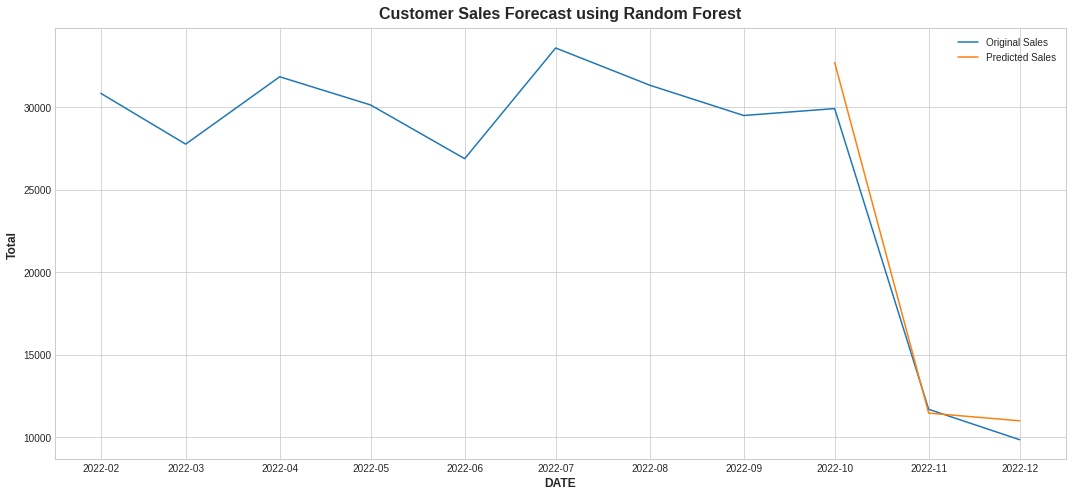

In [48]:
plt.figure(figsize=(15,7))
plt.plot(monthly_sales['Date'], monthly_sales['QTY'])
plt.plot(predict_df['Date'], predict_df['rf_pred'])
plt.title("Customer Sales Forecast using Random Forest")
plt.xlabel("DATE")
plt.ylabel("Total")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()

# XGBoost

In [49]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.2, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

In [50]:
xgb_pred = xgb_pred.reshape(-1,1)
xgb_pred_test_set = np.concatenate([xgb_pred,X_test], axis=1)
xgb_pred_test_set = scaler.inverse_transform(xgb_pred_test_set)


In [51]:
result_list = []
for index in range(0, len(xgb_pred_test_set)):
    result_list.append(xgb_pred_test_set[index][0] + actual_sales[index])
xgb_pred_series = pd.Series(result_list, name='xgb_pred')
predict_df = predict_df.merge(xgb_pred_series, left_index=True, right_index=True)


In [52]:
xgb_rmse = np.sqrt(mean_squared_error(predict_df['xgb_pred'], monthly_sales['QTY'][-3:]))
xgb_mae = mean_absolute_error(predict_df['xgb_pred'], monthly_sales['QTY'][-3:])
xgb_r2 = r2_score(predict_df['xgb_pred'], monthly_sales['QTY'][-3:])
print('XG Boost RMSE: ', xgb_rmse)
print('XG Boost MAE: ', xgb_mae)
print('XG Boost R2 Score: ', xgb_r2)

XG Boost RMSE:  4151.344515789129
XG Boost MAE:  3460.1126364692045
XG Boost R2 Score:  0.6957174713346165


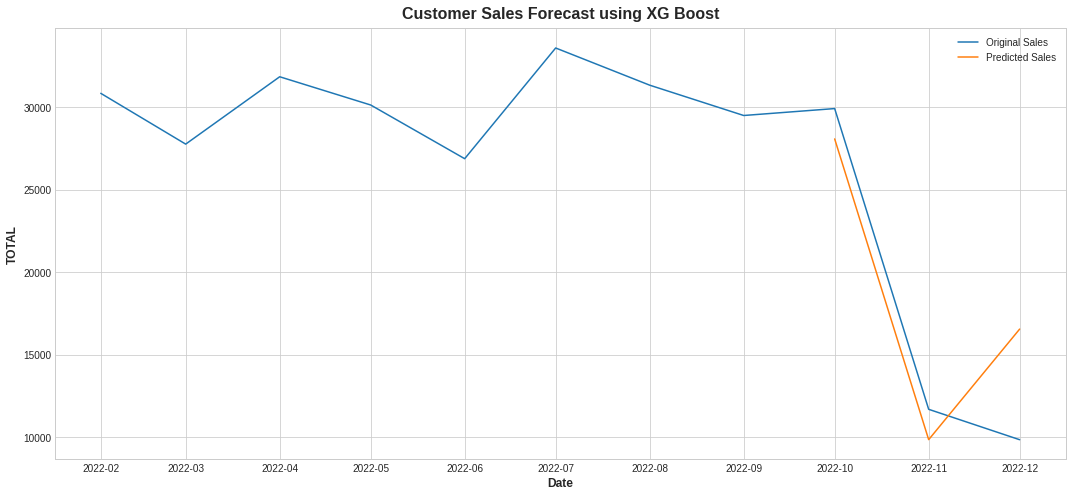

In [53]:
plt.figure(figsize=(15,7))
plt.plot(monthly_sales['Date'], monthly_sales['QTY'])
plt.plot(predict_df['Date'], predict_df['xgb_pred'])
plt.title("Customer Sales Forecast using XG Boost")
plt.xlabel("Date")
plt.ylabel("TOTAL")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()

# Simple LSTM RNN
-> Sequential data, so rnn good choice

In [54]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[0], X_test.shape[1])))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [55]:
# reshape training set 
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1]) 
train_set_scaled = scaler.transform(train_data) 
# reshape test set 
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1]) 
test_set_scaled = scaler.transform(test_data) 
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1] 
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1]) 
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1] 
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [56]:
model = Sequential() 
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True)) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [57]:
checkpoint_filepath = os.getcwd()
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
callbacks = [EarlyStopping(patience=5), model_checkpoint_callback]


In [58]:
history = model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False)


Epoch 1/100
3/3 [==============================] - 2s 7ms/step - loss: 0.1314
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0805
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0666
Epoch 4/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0588
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0516
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0441
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0366
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0294
Epoch 9/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0228
Epoch 10/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0170
Epoch 11/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 12/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0082
Epoch 13/100
3/3 [==============================] - 0s 3ms/st

In [59]:
metrics_df = pd.DataFrame(history.history)
print(metrics_df)

            loss
0   1.314034e-01
1   8.051863e-02
2   6.663987e-02
3   5.881163e-02
4   5.159876e-02
..           ...
95  6.062665e-08
96  6.053856e-08
97  6.052107e-08
98  6.050947e-08
99  6.056514e-08

[100 rows x 1 columns]


In [60]:
lstm_pred = model.predict(X_test, batch_size=1)
lstm_pred = lstm_pred.reshape(-1,1)
#lstm_pred_test_set = np.concatenate([lstm_pred,X_test], axis=1)
#lstm_pred_test_set = scaler.inverse_transform(rf_pred_test_set)


3/3 [==============================] - 1s 4ms/step


In [61]:
result_list = []
for index in range(0, len(lstm_pred)):
    result_list.append(lstm_pred[index][0] + actual_sales[index])
lstm_pred_series = pd.Series(result_list, name='lstm_pred')
predict_df = predict_df.merge(lstm_pred_series, left_index=True, right_index=True)

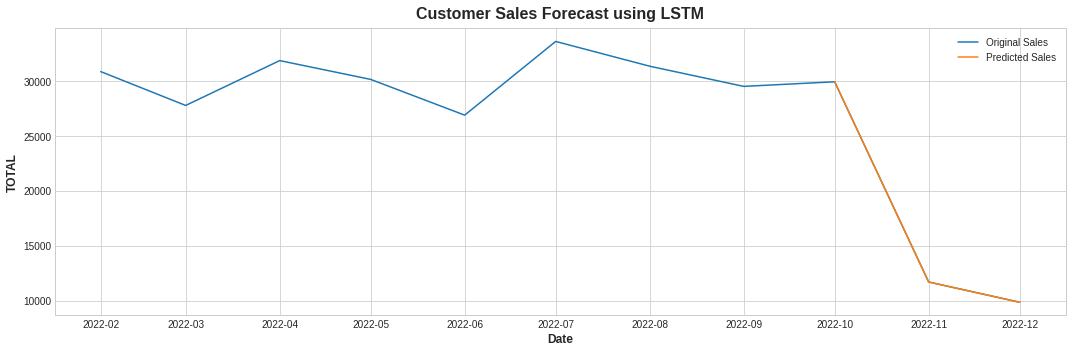

In [62]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['Date'], monthly_sales['QTY'])
plt.plot(predict_df['Date'], predict_df['lstm_pred'])
plt.title("Customer Sales Forecast using LSTM")
plt.xlabel("Date")
plt.ylabel("TOTAL")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()